In [ ]:
pip install -U "jax[cuda12]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.3
    Uninstalling jax-cuda12-pjrt-0.5.3:
      Successfully uninstalled jax-cuda12-pjrt-0.5.3
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.5.3
    Uninstalling jax-cud

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import cupy as cp
import pandas as pd

from jax import random
import time
import matplotlib.pyplot as plt

In [ ]:
gpu = cp.cuda.Device()
print("GPU ID:", gpu.id)
print("GPU name:", cp.cuda.runtime.getDeviceProperties(gpu.id)['name'])

GPU ID: 0
GPU name: b'Tesla T4'


In [ ]:

def lnorm_cp(x, eps=1e-5):
    mean = cp.mean(x, axis=0, keepdims=True)
    var = cp.var(x, axis=0, keepdims=True)
    return (x - mean) / cp.sqrt(var + eps)


def gelu_cp(x):
    return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / cp.pi) * (x + 0.044715 * x**3)))

def softmax_cp(x, mask=None):
    if mask is not None:
        x = cp.where(mask, x, -1e9)
    x_max = cp.max(x, axis=0, keepdims=True)
    e_x = cp.exp(x - x_max)
    return e_x / cp.sum(e_x, axis=0, keepdims=True)

def causal_mask_cp(seq_len):
    return cp.tri(seq_len, seq_len, dtype=bool)


def matmul_cp(WQ, EI):
    Q = WQ @ EI
    return Q


def attention_per_head_decoder_cp(K, Q, V, l_total, ddh, b, h):
    lb = l_total * b
    E2 = cp.zeros((K.shape[0], lb), dtype=cp.float32)
    mask = causal_mask_cp(l_total)

    for j in range(b):
        for i in range(h):
            indJ = j * l_total
            indI2 = i * ddh

            K_slice = K[indI2:indI2+ddh, indJ:indJ+l_total]
            Q_slice = Q[indI2:indI2+ddh, indJ:indJ+l_total]

            E1 = K_slice.T @ Q_slice
            E1 = E1 / cp.sqrt(ddh)
            E1 = softmax_cp(E1, mask=mask)

            V_slice = V[indI2:indI2+ddh, indJ:indJ+l_total]
            result = V_slice @ E1
            E2[indI2:indI2+ddh, indJ:indJ+l_total] = result.astype(cp.float32)

    return E2


def ffn_forward_cp(W1, W2, AO):
    E3b = W1 @ AO
    E3 = gelu_cp(E3b)
    EOb = W2 @ E3
    EO = lnorm_cp(EOb + AO)
    return EO

def mha_output_cp(WO, E2, EI):

    AO = EI + WO @ E2
    AO= lnorm_cp(AO)
    return AO.astype(cp.float32)

b = 1
l = 1
d = 1280
h = 20

f = 5120
ddh = d // h
lb = b * l





In [ ]:

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)

def causal_mask_jax(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len), dtype=bool))


def softmax_jax(x, mask=None, axis=-1):
    if mask is not None:
        x = jnp.where(mask, x, -1e9)
    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)


def matmul_jax(a, b):
    return a @ b


def attention_per_head_decoder_jax(K, Q, V, l_total, ddh, b, h):
    lb = l_total * b
    d = K.shape[0]
    E2_init = jnp.zeros((d, lb), dtype=jnp.float32)
    mask = causal_mask_jax(l_total)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j * l_total
        indI2 = i * ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l_total))
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l_total))
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l_total))

        scores = K_slice.T @ Q_slice / jnp.sqrt(ddh)
        E1 = softmax_jax(scores, mask=mask, axis=0)

        result = V_slice @ E1
        E2 = lax.dynamic_update_slice(E2, result, (indI2, indJ))
        return E2, None

    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)
    return E2


def mha_output_jax(WO, E2, EI):
    AO = WO @ E2 + EI
    AO = lnorm_jax(AO)
    return AO


def ffn_forward_jax(W1, W2, AO):
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3
    EO = lnorm_jax(EOb + AO)
    return EO

In [ ]:

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)


EI_jax = (jax.random.uniform(keys[0], (d, lb), dtype=jnp.float32)  )
WQ = (jax.random.uniform(keys[1], (d, d), dtype=jnp.float32) )
WK = (jax.random.uniform(keys[2], (d, d), dtype=jnp.float32) )
WV = (jax.random.uniform(keys[3], (d, d), dtype=jnp.float32) )
WO = (jax.random.uniform(keys[4], (d, d), dtype=jnp.float32) )
W1 = (jax.random.uniform(keys[5], (f, d), dtype=jnp.float32) )
W2 = (jax.random.uniform(keys[6], (d, f), dtype=jnp.float32) )




In [ ]:
jax.config.update('jax_default_matmul_precision', 'highest')

In [ ]:
EI_cp = cp.zeros( (d, lb),  dtype=cp.float32)
WQ_cp = cp.zeros( (d, d), dtype=cp.float32)
WK_cp = cp.zeros( (d, d),  dtype=cp.float32)
WV_cp = cp.zeros((d, d),  dtype=cp.float32)
WO_cp = cp.zeros( (d, d),  dtype=cp.float32)
W1_cp = cp.zeros( (f, d),  dtype=cp.float32)
W2_cp = cp.zeros((d, f),dtype=cp.float32)
results={}

In [ ]:

results = {"CuPy": {}}



start = time.time()
Qc = matmul_cp(WQ_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_Q"] = end - start


start = time.time()
Kc = matmul_cp(WK_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_cp(WV_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_V"] = end - start

start = time.time()
E2n = attention_per_head_decoder_cp(Kc, Qc, Vc, l, ddh, b, h)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["attention"] = end - start


start = time.time()
AOc = mha_output_cp(WO_cp, E2n, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["mha_output"] = end - start


start = time.time()
EOc = ffn_forward_cp(W1_cp, W2_cp, AOc)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["ffn"] = end - start


results["CuPy"]["total"] = sum(results["CuPy"].values())
print(results["CuPy"])


{'matmul_Q': 0.1479332447052002, 'matmul_K': 0.003042459487915039, 'matmul_V': 0.006731986999511719, 'attention': 4.321296691894531, 'mha_output': 1.2227768898010254, 'ffn': 1.4799346923828125, 'total': 7.181715965270996}


In [ ]:
# JAX without JIT
results["JAX"] = {}


start = time.time()
Qj = matmul_jax(WQ, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start


start = time.time()
E2j = attention_per_head_decoder_jax(Kj, Qj, Vj, l_total=l, ddh=ddh, b=b, h=h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start


start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start


start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start


results["JAX"]["total"] = sum(results["JAX"].values())




In [ ]:
results["JIT-COMP"] = {}

# JIT
matmul_jit= jax.jit(matmul_jax)

attention_per_head_jit = jax.jit(attention_per_head_decoder_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)




start = time.time()
Qj = matmul_jax(WQ, EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start


start = time.time()
Kj = matmul_jax(WK, EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start


start = time.time()
Vj = matmul_jax(WV, EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn

results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())


In [ ]:
# JAX con JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start



start_attention=  time.time()
E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t

start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

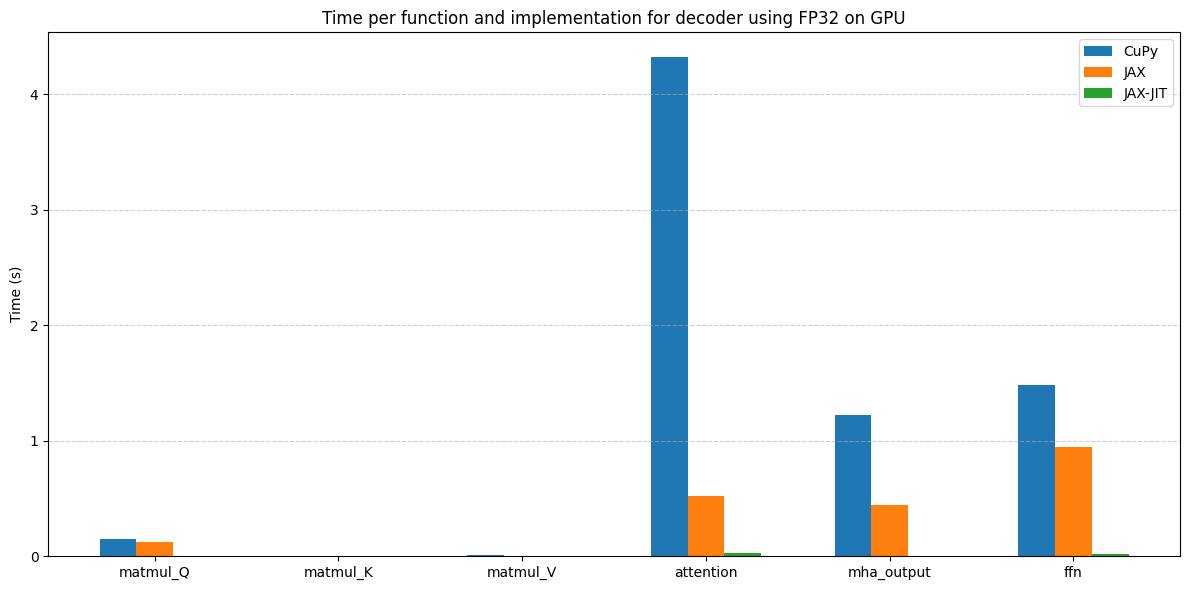

In [ ]:



labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20
fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - 1*width, [results["CuPy"][l] for l in labels], width, label='CuPy')
ax.bar(x + 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function and implementation for decoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()



plt.show()

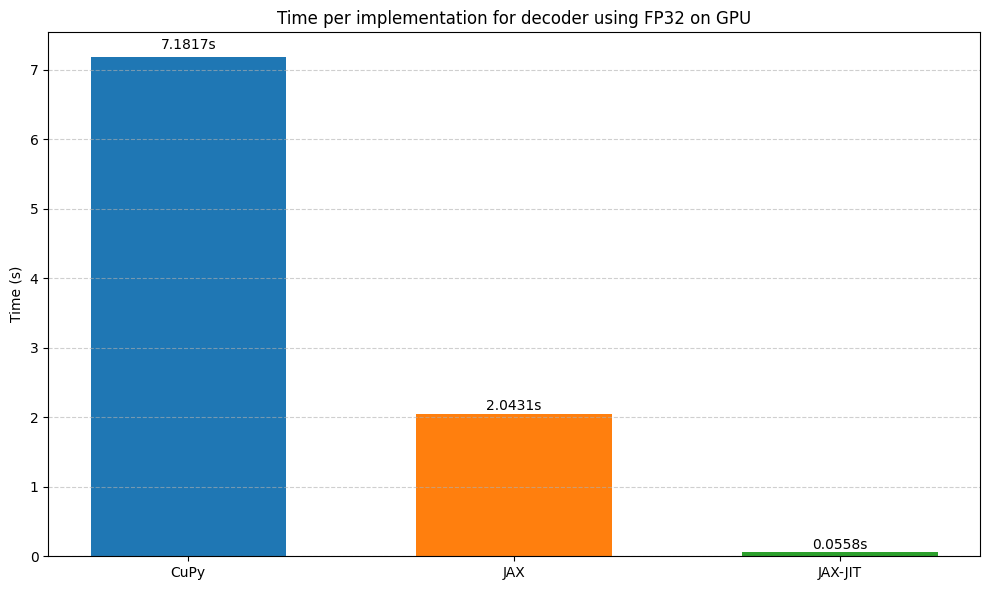

In [ ]:

labels = ["CuPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Time per implementation for decoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()



plt.show()

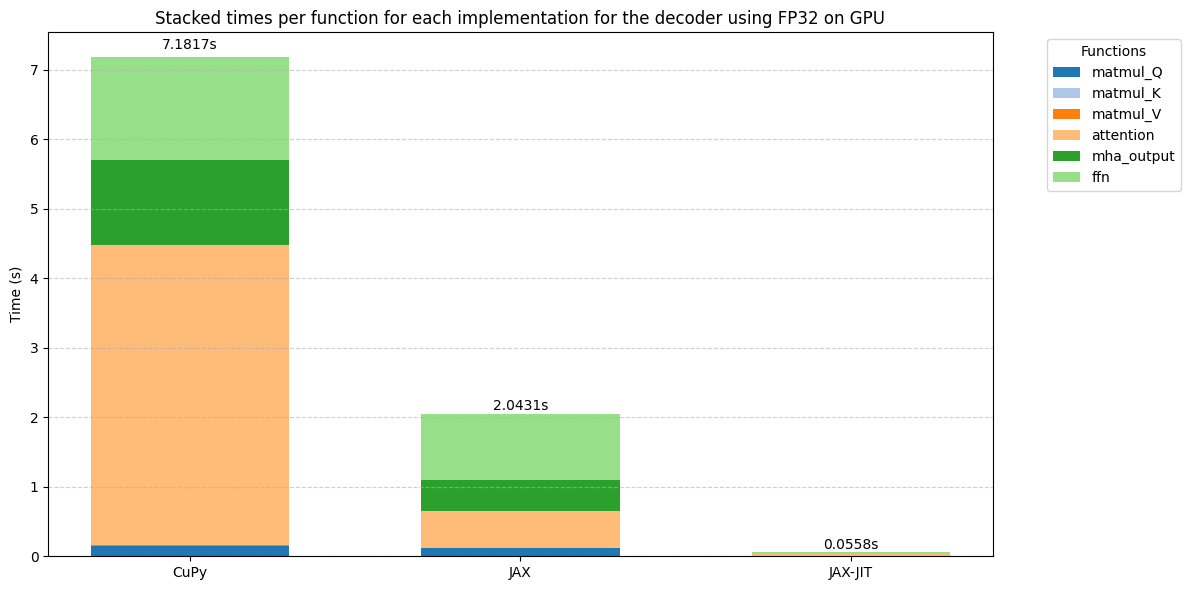

In [ ]:

implementations = ["CuPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(implementations))

for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the decoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)

ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [ ]:
df = pd.DataFrame(results).T

In [ ]:
df

,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
CuPy,0.147933,0.003042,0.006732,4.321297,1.222777,1.479935,7.181716
JAX,0.121664,0.001717,0.001614,0.525118,0.444228,0.948770,2.043111
JIT-COMP,0.002901,0.002643,0.002616,0.285597,0.181811,0.221658,0.697227
JAX-JIT,0.002691,0.002637,0.002616,0.025586,0.003129,0.019173,0.055831
